In [2]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(ggbeeswarm)
library(Hmisc)
library(RColorBrewer)
library(stringr)
library(extrafont)
library(tidyr)
loadfonts(device = "pdf")
library(ggpubr)
library(Biostrings)
library(jgplot2)
if(any(grepl("package:plyr", search()))) detach("package:plyr")

In [3]:
theme_set(theme_classic() + 
          theme(axis.title.x = element_text(
                    size = rel(1)),
                axis.title.y = element_text(size = rel(1))
                , legend.position = "none",
                strip.background = element_blank(), strip.placement = "outside"
              ,strip.text.x = element_text(vjust = 2, size = rel(11/9))
              , axis.ticks.y = element_line(color = "black") 
                , axis.ticks.x = element_blank(), panel.spacing.x = unit(0, "null")
               ,plot.title = element_text(size = rel(1))
         ,axis.text.x = element_text(colour = "black", size = rel(11/9))
          ,axis.text.y = element_text(colour = "black", size = rel(11/9))
               ,text = element_text(family="ArialMT", size = 11)
          ,plot.margin = margin(0, 0, 0, 0, "in"),
              plot.background = element_rect(fill='transparent', color=NA),
              panel.background = element_rect(fill='transparent', color=NA),
              rect = element_rect(fill = "transparent")
         ))

In [17]:
summary_all <- read.delim("data/CRISPResso_summary.txt")
summary_all <- summary_all[, c("Batch", "Correct_edit", "Indels", "Reads_aligned_all_amplicons")]
summary_all <- gather(summary_all, key = "Edit_Type", value = "Percent", -Batch, -Reads_aligned_all_amplicons)
summary_all$rep <- gsub("_.*", "", summary_all$Batch)
summary_all$celltype <-  gsub("_.*", "", gsub("REP[1-3]_", "", summary_all$Batch))
summary_all$locus <- gsub(".*_", "", gsub("_type.*", "", summary_all$Batch))
summary_all$insert <- ifelse(grepl("GCTGC", summary_all$Batch), "GCTGC",
                            ifelse(grepl("GTCAG", summary_all$Batch), "GTCAG", NA))
summary_all$HR <- as.numeric(gsub(".*_", "", summary_all$Batch))
summary_all$color <- as.character(as.numeric(as.factor(paste0(summary_all$Edit_Type, summary_all$insert))))
summary_all$color <- factor(summary_all$color, levels= c('1','3','2','4'))
summary_all$Percent <- as.numeric(summary_all$Percent)
summary_all$celltype <- factor(summary_all$celltype, levels = c('HEKcells', 'WtTScells'
                                                                , 'OrthoTS1cells', 'OrthoTS2cells'))

In [19]:
plot_results_ortho <- function(summary_all, locus) {
    ggplot(summary_all[summary_all$locus == locus & !grepl("endogenous",summary_all$Batch) ,], 
       aes(x = as.character(HR),y = Percent, fill = color)) + 
        geom_bar(stat = "summary", fun = "mean",position = position_dodge(width = 0.9)
        , color = "black", size=0.25, width = 0.8) + 
        stat_summary(fun.data = "mean_sdl", fun.args = list(mult = 1), geom = "errorbar"
            , position = position_dodge(width = 0.9), width = 0.4, size = 0.25) + 
        geom_beeswarm(dodge.width = 0.9, size = 1, cex = 1) + 
        facet_grid(. ~ celltype, scales = "free_x", space='free'
                   , labeller = as_labeller(c(WtTScells = "WT", OrthoTS1cells = "Ortho v1"
                                              , OrthoTS2cells = "Ortho v2"))) +
        xlab("RT Lengths") +
        scale_fill_manual(values = c(brewer.pal(n = 3, name = "Set1")[1], "lightgrey",
                          brewer.pal(n = 3, name = "Set1")[2], "lightgrey"), 
                          labels = c("Edits BC1", "Indels BC1", "Edits BC2", "Indels BC2"), name = ""
                          ) +
        ylab("Total sequencing reads with\nspecified edit or indels (%)") + 
        ggtitle(paste0(locus, " target site editing")) +scale_x_discrete(expand=expansion(add=0.75)) +
        scale_y_continuous(breaks=seq(0,70,by = 10), limits=c(0, 75), expand = c(0, 0)) + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
}

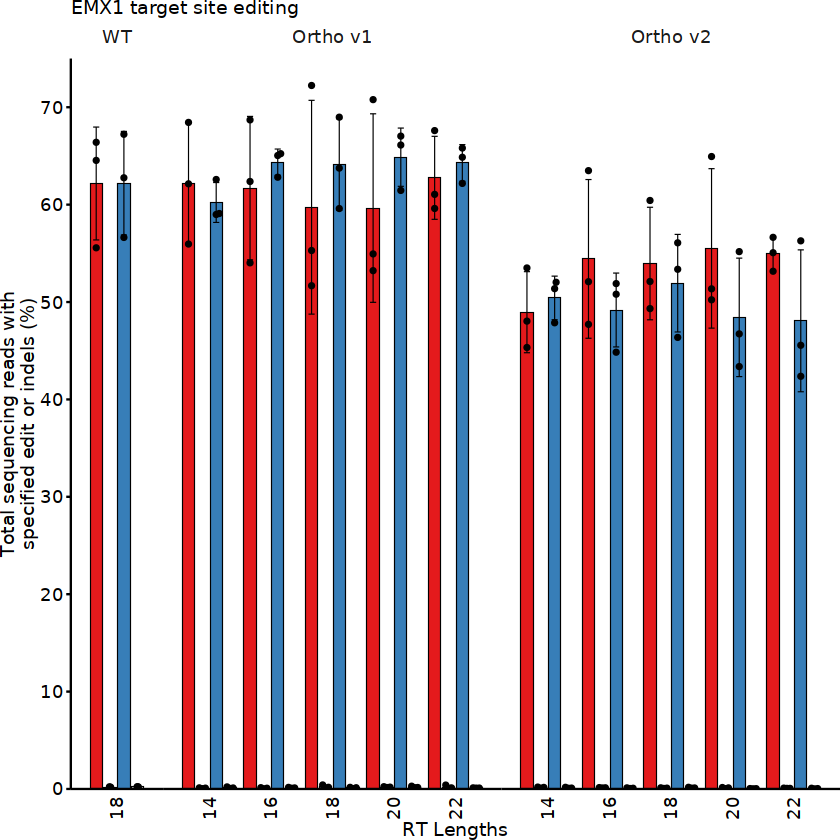

In [20]:
pdf('plots/OrthoTS_EMX1_TargetSite.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_ortho(summary_all, "EMX1")
dev.off()

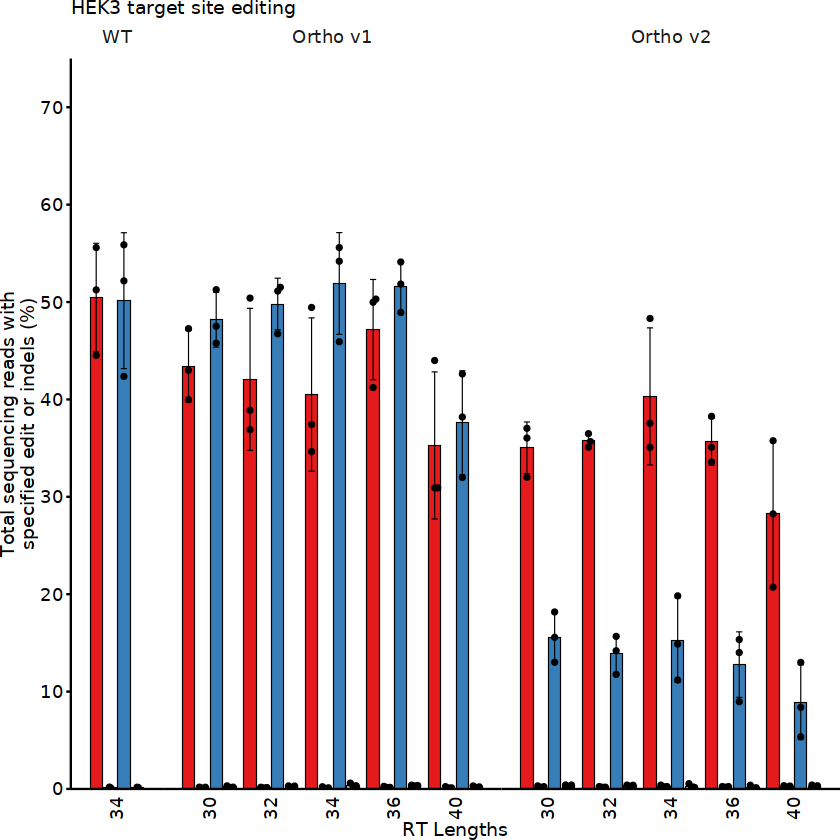

In [21]:
pdf('plots/OrthoTS_HEK3_TargetSite.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_ortho(summary_all, "HEK3")
dev.off()

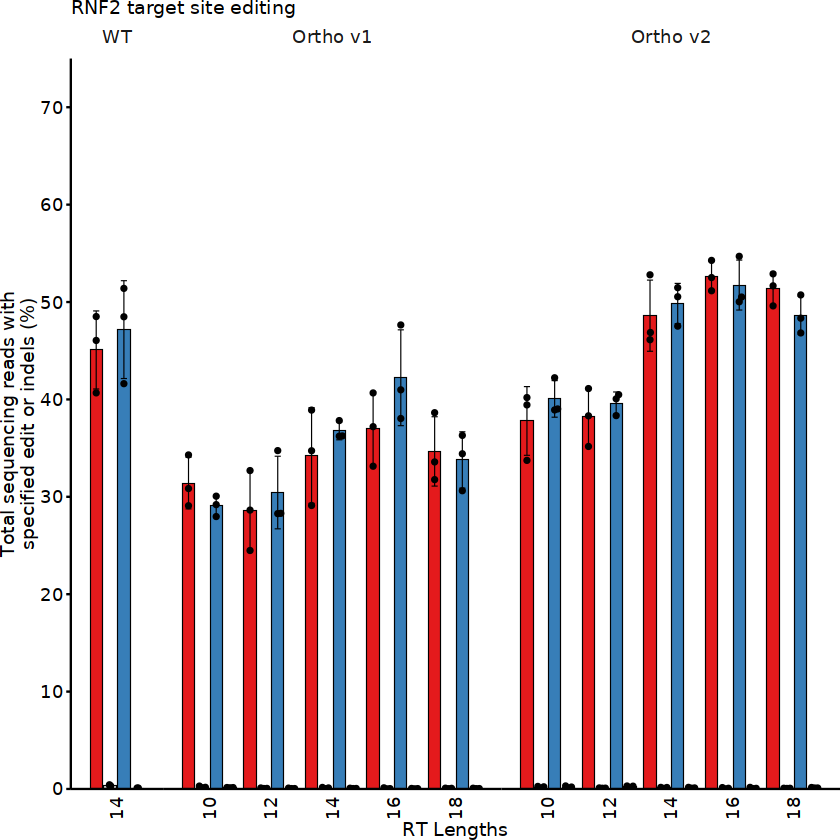

In [22]:
pdf('plots/OrthoTS_RNF2_TargetSite.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_ortho(summary_all, "RNF2")
dev.off()

In [31]:
plot_results_endogenous <- function(summary_all, locus) {
    summary_all_plot <- summary_all[summary_all$locus == locus & grepl("endogenous",summary_all$Batch) & 
                                    !grepl("HEKcells", summary_all$celltype),]
    summary_all_plot$celltype <- plyr::mapvalues(summary_all_plot$celltype
                                                 , from = c('OrthoTS1cells', 'OrthoTS2cells', 'WtTScells')
                                                , to = c("Ortho v1", "Ortho v2", "WT"))
    ggplot(summary_all_plot, 
           aes(x = as.character(HR),y = Percent, fill = color)) + 
        geom_bar(stat = "summary", fun = "mean",position = position_dodge(width = 0.9)
        , color = "black", size=0.25, width = 0.8) + 
        stat_summary(fun.data = "mean_sdl", fun.args = list(mult = 1), geom = "errorbar"
            , position = position_dodge(width = 0.9), width = 0.4, size = 0.25) + 
        geom_beeswarm(dodge.width = 0.9, size = 1, cex = 1) + 
        facet_grid(. ~ celltype, scales = "free_x", space = "free") +
        xlab("RT Lengths") +
        scale_fill_manual(values = c(brewer.pal(n = 3, name = "Set1")[1], "lightgrey"
                                     ,brewer.pal(n = 3, name = "Set1")[2], "lightgrey"), 
                          labels = c("Edits BC1", "Indels BC1", "Edits BC2", "Indels BC2"), name = "") +
        ylab("Total sequencing reads with\nindicated barcode insertion (%)") + 
        ggtitle(paste0(locus, " Endogenous"))+ 
        scale_x_discrete(expand=expansion(add=0.75)) +
        scale_y_continuous(breaks=seq(0,70,by = 10), limits=c(0, 75), expand = c(0, 0))  + 
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    }

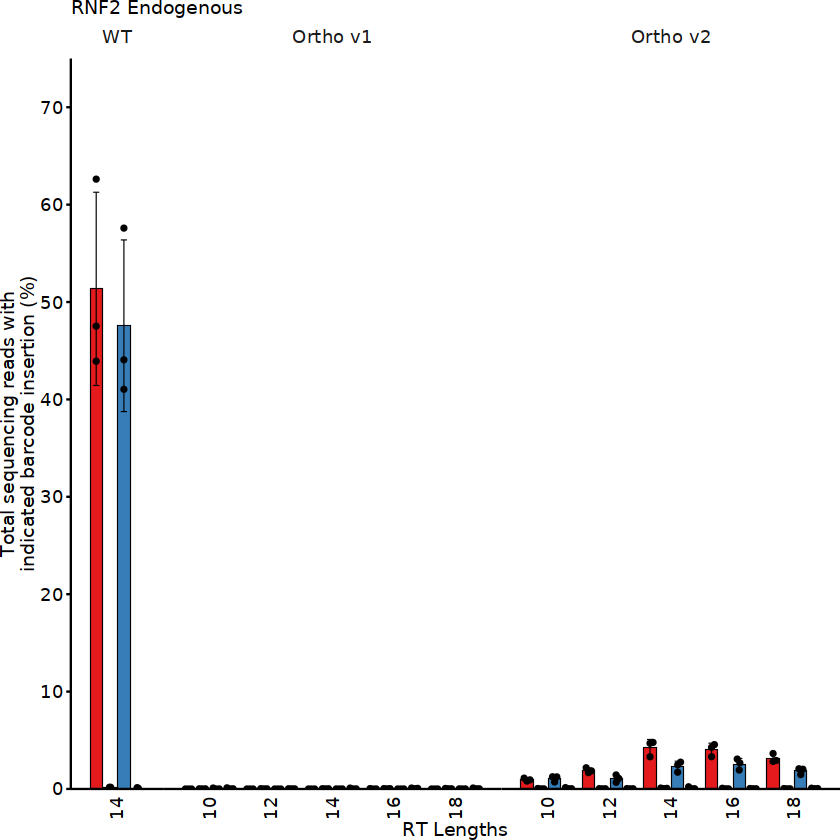

In [32]:
pdf('plots/OrthoTS_RNF2_Endogenous.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_endogenous(summary_all, "RNF2")
dev.off()

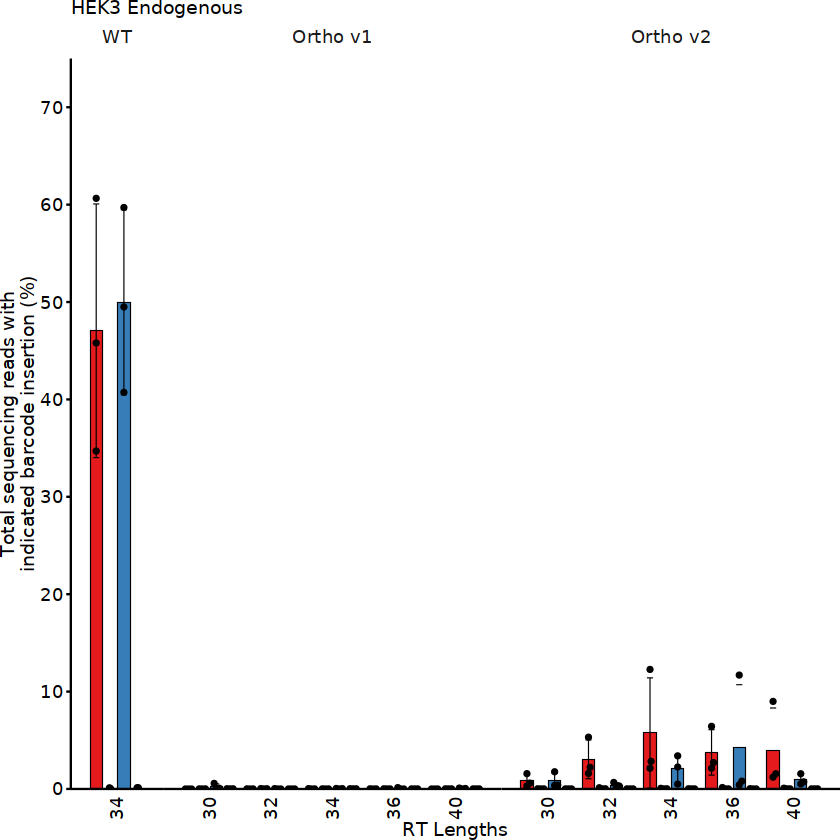

In [33]:
pdf('plots/OrthoTS_HEK3_Endogenous.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_endogenous(summary_all, "HEK3")
dev.off()

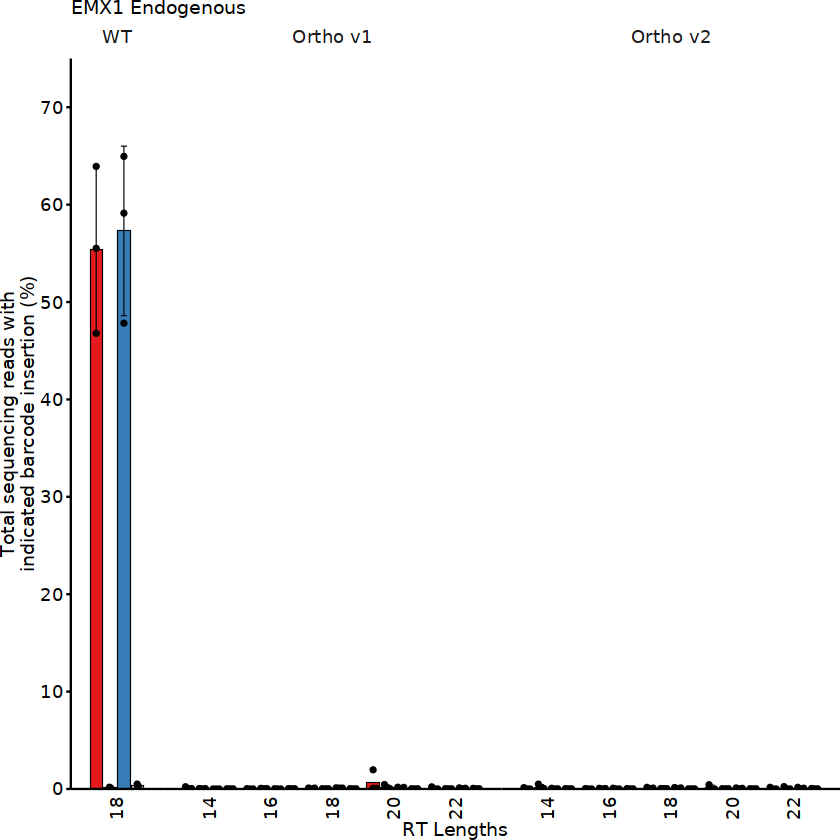

In [34]:
pdf('plots/OrthoTS_EMX1_Endogenous.pdf', width = 2.65, height = 2.25, useDingbats = FALSE)
plot_results_endogenous(summary_all, "EMX1")
dev.off()